# Problem 7.1

Attribution: Elena and Shashank

First we load the necessary modules.

In [177]:
import glob
import os
import warnings
import time
from numba import jit
import itertools
import emcee

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.signal
import scipy.stats as st

# BE/Bi 103 utilities
import bebi103

# Image processing tools
import skimage
import skimage.io

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Suppress future warnings
warnings.filterwarnings('ignore')

Let's load the data.

In [55]:
# The directory containing daytime data
data_dir_day = '/Users/elenaperry/Dropbox/Caltech/bebi103/Cassiopea_Pulsation/day'

# Glob string for day images
im_glob_day = os.path.join(data_dir_day, '*.TIF')

# The directory containing nighttime data
data_dir_night = '/Users/elenaperry/Dropbox/Caltech/bebi103/Cassiopea_Pulsation/night'

# Glob string for night images
im_glob_night = os.path.join(data_dir_night, '*.TIF')

For each jellyfish, we chose the ROI vertices using `plt.ginput(100)`.

In [147]:
verts1 = np.array([(35.863636363636388, 107.22727272727269),
 (173.59090909090912, 111.31818181818176),
 (168.13636363636368, 223.13636363636363),
 (34.500000000000014, 216.31818181818181)])
 
verts2 = np.array([(185.86363636363643, 100.40909090909088),
 (338.59090909090918, 111.31818181818176),
 (330.40909090909099, 232.68181818181813),
 (185.86363636363643, 224.5)])
 
verts3 = np.array([(349.50000000000006, 99.045454545454504),
 (498.13636363636374, 100.40909090909088),
 (495.40909090909099, 236.77272727272725),
 (348.13636363636368, 238.13636363636363)])
 
verts4 = np.array([(504.9545454545455, 90.863636363636317),
 (635.86363636363649, 97.68181818181813),
 (634.50000000000011, 244.95454545454544),
 (506.31818181818187, 239.5)])

verts5 = np.array([(38.590909090909108, 232.68181818181813),
 (173.59090909090912, 239.5),
 (169.50000000000006, 379.95454545454544),
 (34.500000000000014, 363.59090909090907)])

verts6 = np.array([(184.50000000000006, 250.40909090909088),
 (335.86363636363643, 253.13636363636363),
 (331.77272727272731, 392.22727272727275),
 (177.68181818181824, 386.77272727272725)])

verts7 = np.array([(345.40909090909099, 249.0454545454545),
 (492.68181818181824, 250.40909090909088),
 (485.86363636363649, 393.59090909090907),
 (345.40909090909099, 389.5)])

verts8 = np.array([(502.22727272727275, 250.40909090909088),
 (633.13636363636374, 255.86363636363632),
 (633.13636363636374, 393.59090909090907),
 (503.59090909090912, 393.59090909090907)])

all_verts = np.array([verts1, verts2, verts3, verts4,
                  verts5, verts6, verts7, verts8])

To help us identify peaks, we write a function that uses the quadratic fitting method to get a local maximum.

In [7]:
def local_min(x, y):
    """
    Fit three points to quadratic and return location of maximum or minimum.
    """
    a, b, c = np.polyfit(x, y, 2)
    x_max = -b / 2 / a
    return x_max, a*x_max**2 + b*x_max + c

Next, we at first attempted to get the intercontraction times for each jellyfish using code from tutorial 8, which we repackaged into two functions as shown below.

In [41]:
def load_roi(fname, roi_bbox=None):
    """
    To be used as load_func in skimage.io.ImageCollection.
    Returns region bounding ROI.
    """
    if roi_bbox is None:
        return skimage.io.imread(fname)[0,:,:]
    else:
        return skimage.io.imread(fname)[0,:,:][roi_bbox]

def intercontraction_times_slow(verts, im_glob, im_shape=(480,640), fps=15):
    """
    Calculate intercontraction times (seconds) for one jellyfish.
    Returns array of time stamps for the images, array of total 
    intensities rescaled to go from -1 to 1, array of times of 
    peak maxima, array of peak maxima, and array of intercontraction 
    times.
    """
    # Unpack image dimensions
    y_dim, x_dim = im_shape
    
    # Define ROI
    roi, roi_bbox, roi_box = bebi103.verts_to_roi(verts, y_dim, x_dim)

    # Load image collection
    ic = skimage.io.ImageCollection(im_glob, conserve_memory=True, 
                                    load_func=load_roi, roi_bbox=roi_bbox)
    
    # Generate timestamps for the images
    t = np.arange(0, len(ic)) / fps

    # Set up Numpy array to store total pixel intensity
    total_int = np.empty(len(t))

    # Look through and compute total intensity in the ROI
    for i, im in enumerate(ic):
        total_int[i] = ic[i][roi_box].sum()

    # Subtract the mean and rescale the data to go from -1 to 1
    total_int -= total_int.mean()
    total_int = 1 + 2 / (total_int.max() - total_int.min()) \
                    * (total_int - total_int.max())

    # Find up and down crossing indices
    up_crossing_inds = np.where(
        np.logical_and(total_int[:-1] < 0, total_int[1:] >= 0))[0]
    down_crossing_inds = np.where(
        np.logical_and(total_int[:-1] > 0, total_int[1:] <= 0))[0] + 1

    # Make sure upcrossing are first
    if down_crossing_inds[0] < up_crossing_inds[0]:
        down_crossing_inds = down_crossing_inds[1:]

    # Make sure downcrossing last
    if up_crossing_inds[-1] > down_crossing_inds[-1]:
        up_crossing_inds = up_crossing_inds[:-1]

    # Find maxima
    t_peaks = np.empty(len(up_crossing_inds))
    peaks = np.empty_like(t_peaks)
    for i, uc in enumerate(up_crossing_inds):
        ind = uc + np.argmax(total_int[uc:down_crossing_inds[i]+1])
        t_peaks[i], peaks[i] = local_min(t[ind-1:ind+2], total_int[ind-1:ind+2])

    # Intercontractions times
    t_int = np.diff(t_peaks)
    
    return t, total_int, t_peaks, peaks, t_int

However, we found that this code ran slower than we would like - it was averaging a little over 12 minutes per jellyfish:

In [46]:
start = time.time()
t1, total_int1, t_peaks1, peaks1, t_int1 = intercontraction_times_slow(all_verts[6], im_glob_day)
print('intercontraction_times_slow took ' + str(time.time()-start) + ' seconds')

intercontraction_times_slow took 745.6605441570282 seconds


Thus, we decided to try using `Numba` to speed up our code. In order to do so, we first wrote a function to load the images in as a single 3-dimensional `Numpy` array instead of as a `skimage ImageCollection`. Then we used `Numba` to speed up the processes of iterating over all of the images and peaks. 

In [56]:
def get_roi(verts, im_glob, im_shape=(480,640)):
    """
    Returns as a Numpy array the smallest square subimage 
    that completely contains the ROI.
    """
    # Unpack image dimensions
    y_dim, x_dim = im_shape
    
    # Define ROI
    roi, roi_bbox, roi_box = bebi103.verts_to_roi(verts, y_dim, x_dim)
    
    # Load images and store only the region that bounds the ROI
    im_list = glob.glob(im_glob)
    ims = [None] * len(im_list)
    for i in range(len(im_list)):
        ims[i] = scipy.ndimage.imread(im_list[i])[roi_bbox]

    ims = np.array(ims) 
    return ims, roi, roi_bbox, roi_box

@jit
def intercontraction_times_fast(ims, roi_box, fps=15):
    """
    Calculate intercontraction times using the power of Numba
    to speed up the for loops ~500x.
    """
    # Generate timestamps for the images
    t = np.arange(0, len(ims)) / fps

    # Set up Numpy array to store total pixel intensity
    total_int = np.empty(len(t))

    # Look through and compute total intensity in the ROI
    for i in range(len(ims)):
        total_int[i] = ims[i][roi_box].sum()

    # Subtract the mean and rescale the data to go from -1 to 1
    total_int -= total_int.mean()
    total_int = 1 + 2 / (total_int.max() - total_int.min()) \
                    * (total_int - total_int.max())

    # Find up and down crossing indices
    up_crossing_inds = np.where(
        np.logical_and(total_int[:-1] < 0, total_int[1:] >= 0))[0]
    down_crossing_inds = np.where(
        np.logical_and(total_int[:-1] > 0, total_int[1:] <= 0))[0] + 1

    # Make sure upcrossing are first
    if down_crossing_inds[0] < up_crossing_inds[0]:
        down_crossing_inds = down_crossing_inds[1:]

    # Make sure downcrossing last
    if up_crossing_inds[-1] > down_crossing_inds[-1]:
        up_crossing_inds = up_crossing_inds[:-1]

    # Find maxima
    t_peaks = np.empty(len(up_crossing_inds))
    peaks = np.empty_like(t_peaks)
    for i, uc in enumerate(up_crossing_inds):
        ind = uc + np.argmax(total_int[uc:down_crossing_inds[i]+1])
        t_peaks[i], peaks[i] = local_min(t[ind-1:ind+2], total_int[ind-1:ind+2])

    # Intercontractions times
    t_int = np.diff(t_peaks)
    
    return t, total_int, t_peaks, peaks, t_int

Fortunately, we found that this approach reduced our computation time by more than 25-fold (the limiting step being the image loading).  

In [57]:
start = time.time()
ims, roi, roi_bbox, roi_box = get_roi(all_verts[6], im_glob_day)
print('get_roi took ' + str(time.time()-start) + ' seconds')

start = time.time()
t2, total_int2, t_peaks2, peaks2, t_int2 = intercontraction_times_fast(ims, roi_box)
print('intercontraction_times_fast took ' + str(time.time()-start) + ' seconds')

get_roi took 25.83569312095642 seconds
intercontraction_times_fast took 1.296436071395874 seconds


Just to make sure we were actually calculating the same things with the new functions as what we calculated in tutorial 8, we plotted the raw data and peaks for jellyfish 7 using both approaches. 

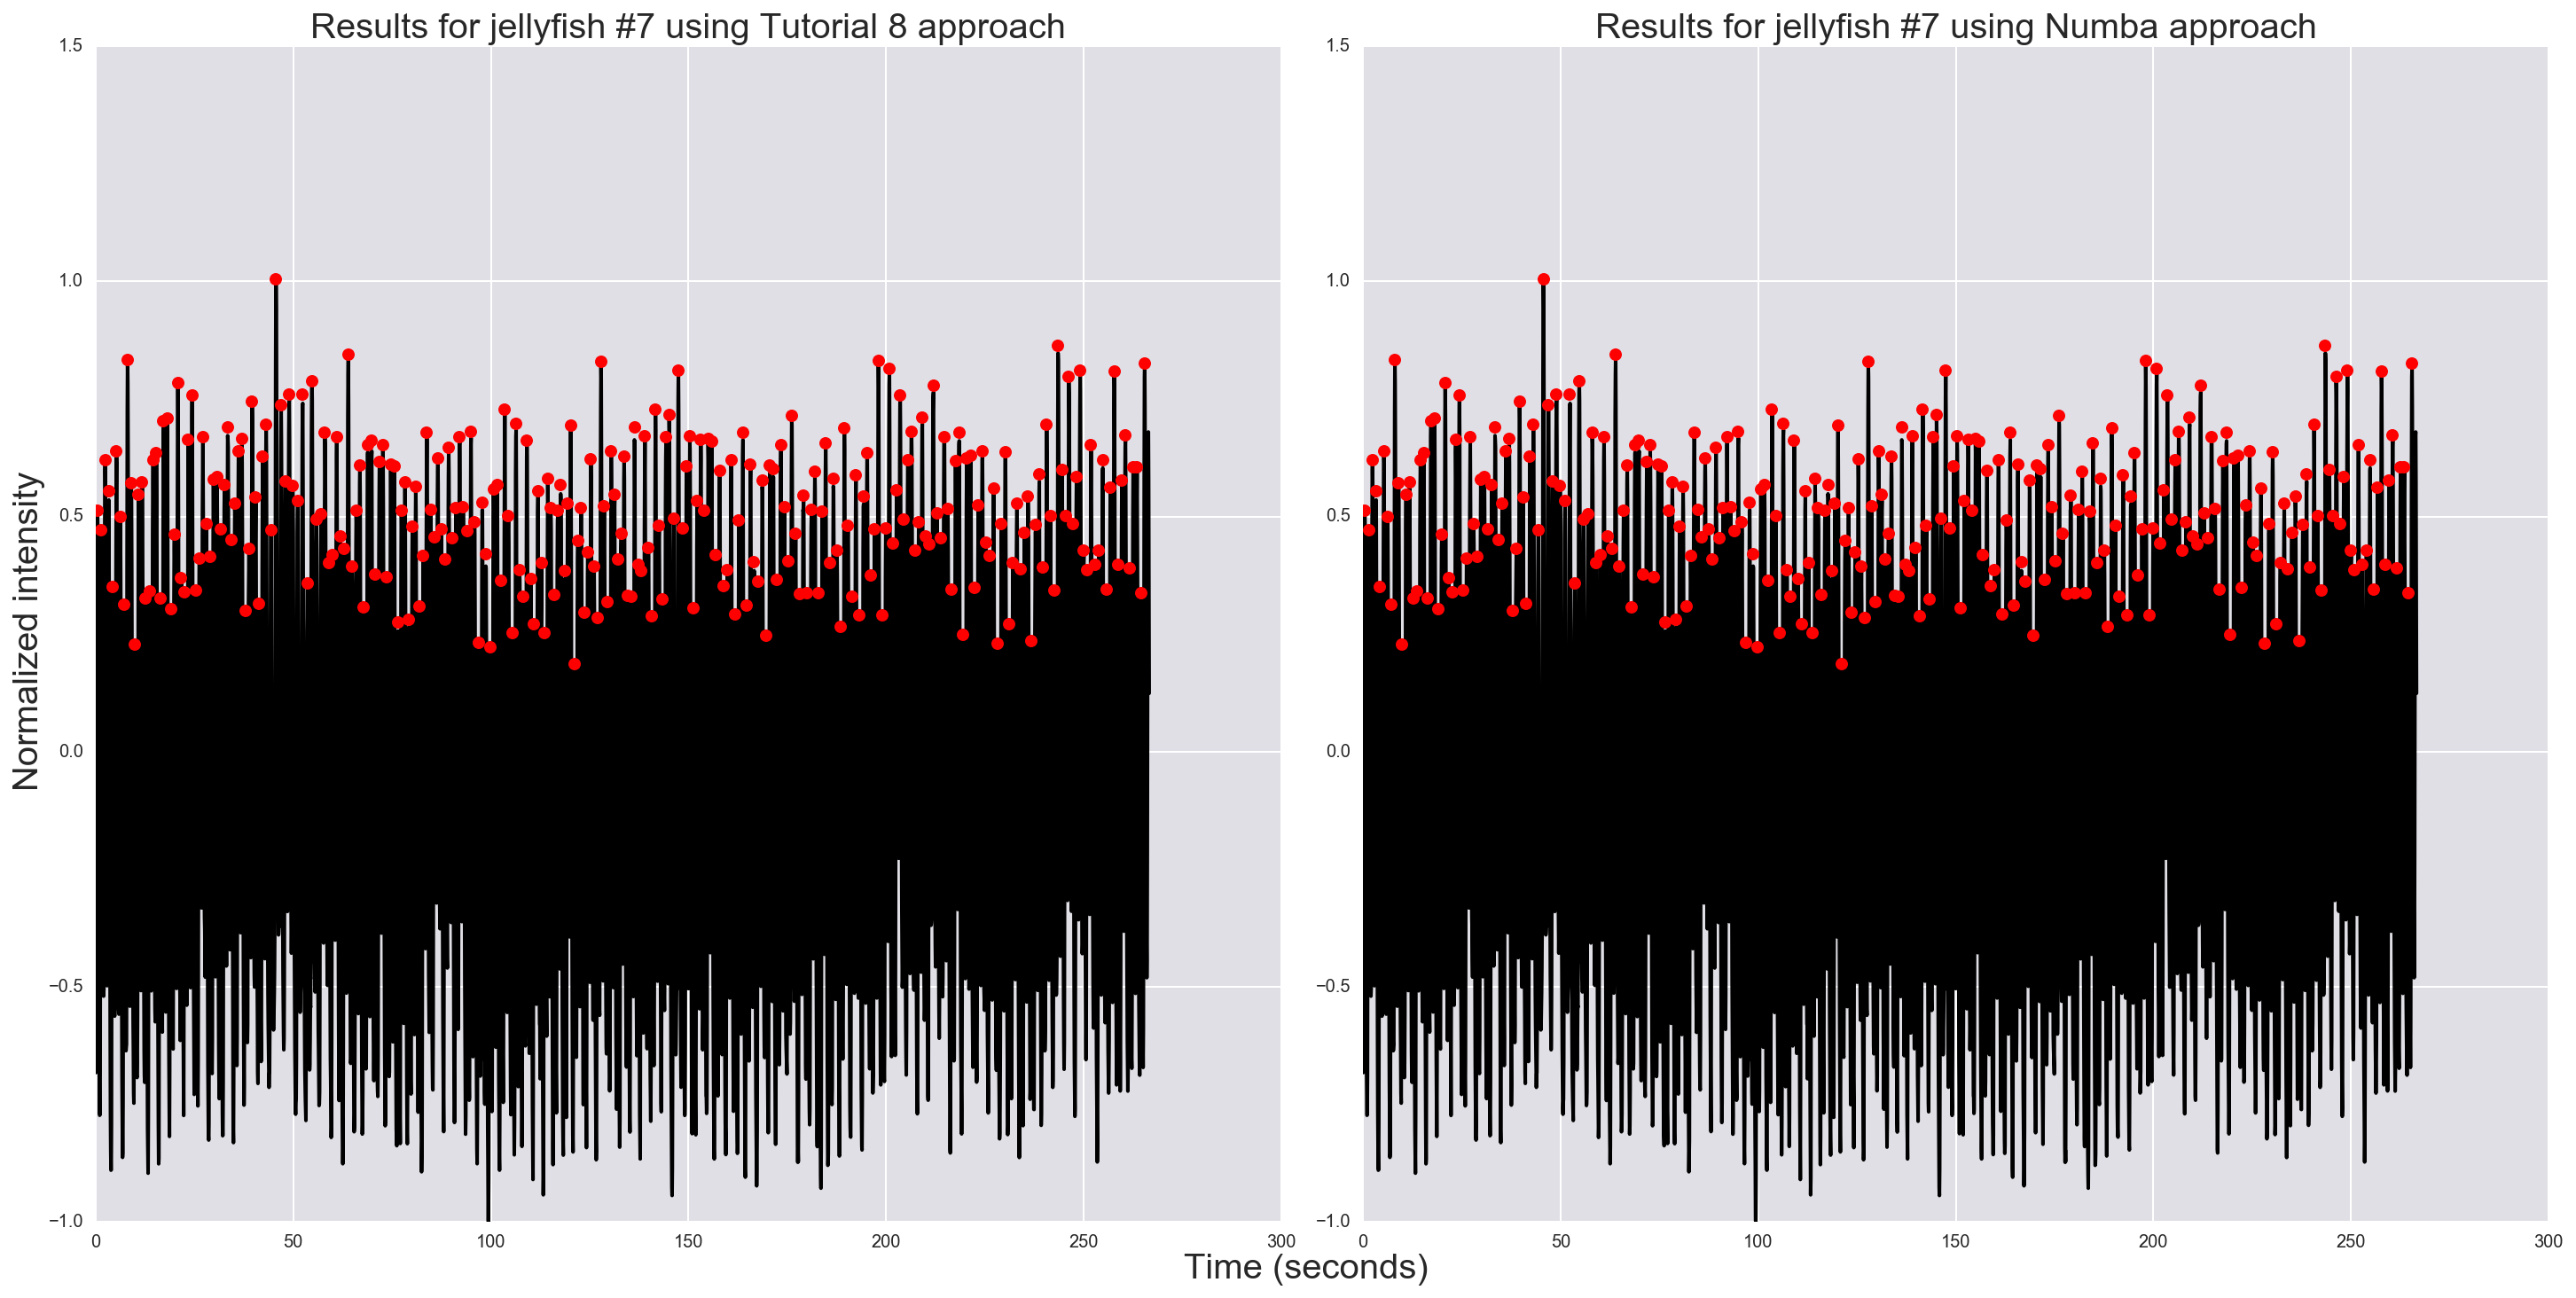

In [151]:
f = plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.plot(t1, total_int1, color='k')
plt.plot(t_peaks1, peaks1, marker='o', linestyle='None', color='r')
plt.title('Results for jellyfish #7 using Tutorial 8 approach', fontsize=20)

plt.subplot(1,2,2)
plt.plot(t2, total_int2, color='k')
plt.plot(t_peaks2, peaks2, marker='o', linestyle='None', color='r')
plt.title('Results for jellyfish #7 using Numba approach', fontsize=20)

# Set common labels
f.text(0.5, 0.0, 'Time (seconds)', ha='center', va='center', fontsize=20)
f.text(0.0, 0.5, 'Normalized intensity', ha='center', va='center', rotation='vertical', fontsize=20)
plt.tight_layout()

As we expected, the plots look exactly the same, so we felt comfortable using the `Numba` approach for all of the jellyfish. We proceeded to get the intercontraction times for each jellyfish during the day and the night. 

In [70]:
# Get the daytime raw data and intercontraction times for all 8 jellyfish
t_arr_day = np.empty((len(all_verts), 4000))
total_int_arr_day = np.empty((len(all_verts), 4000))
t_peaks_list_day = []
peaks_list_day = []
t_int_list_day = [] 

for i in range(len(all_verts)):
    ims, roi, roi_bbox, roi_box = get_roi(all_verts[i], im_glob_day)
    t, total_int, t_peaks, peaks, t_int = intercontraction_times_fast(ims, roi_box)
    t_arr_day[i,:] = t
    total_int_arr_day[i,:] = total_int
    t_peaks_list_day.append(t_peaks)
    peaks_list_day.append(peaks)
    t_int_list_day.append(t_int)

# Get the nighttime raw data and intercontraction times for all 8 jellyfish
t_arr_night = np.empty((len(all_verts), 4000))
total_int_arr_night = np.empty((len(all_verts), 4000))
t_peaks_list_night = []
peaks_list_night = []
t_int_list_night = []

for i in range(len(all_verts)):
    ims, roi, roi_bbox, roi_box = get_roi(all_verts[i], im_glob_night)
    t, total_int, t_peaks, peaks, t_int = intercontraction_times_fast(ims, roi_box)
    t_arr_night[i,:] = t
    total_int_arr_night[i,:] = total_int
    t_peaks_list_night.append(t_peaks)
    peaks_list_night.append(peaks)
    t_int_list_night.append(t_int)

We'll soon get to analyzing the intercontraction times directly, but first let's take a look at the jellyfish activity during the day:

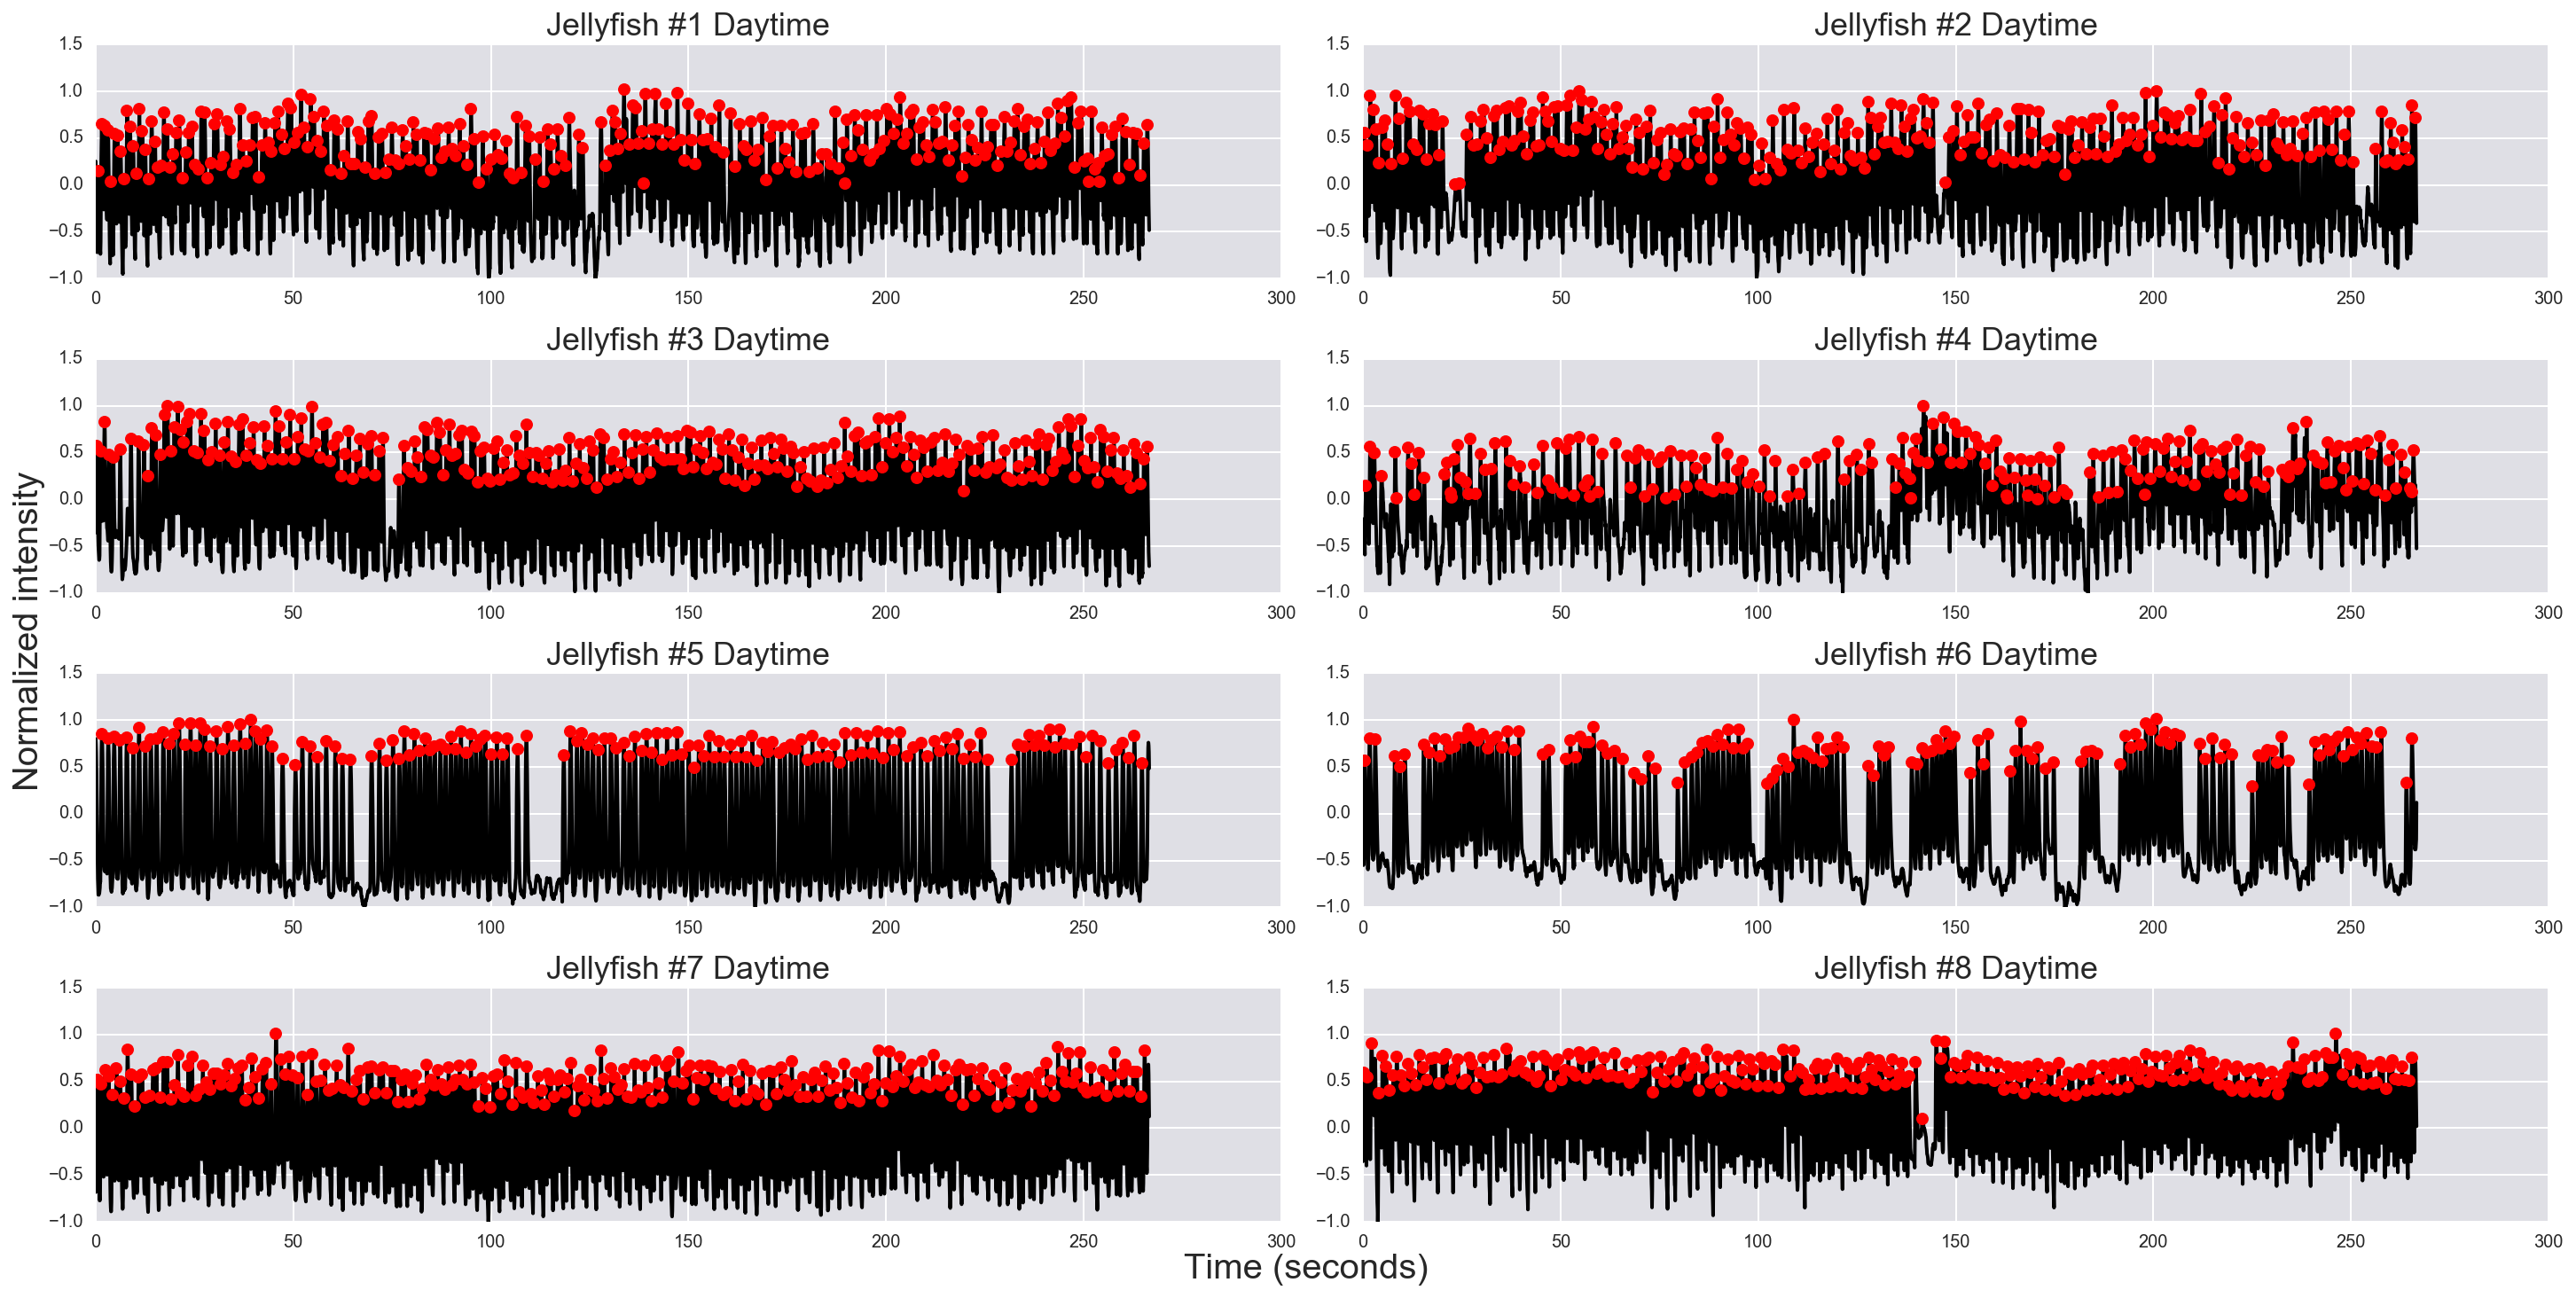

In [88]:
# Make plots for daytime activity of each jellyfish
f = plt.figure(figsize=(20,10))
plt.subplot(4,2,1)
plt.plot(t_arr_day[0], total_int_arr_day[0], color='k')
plt.plot(t_peaks_list_day[0], peaks_list_day[0], marker='o', linestyle='None', color='r')
plt.title('Jellyfish #1 Daytime')

plt.subplot(4,2,2)
plt.plot(t_arr_day[1], total_int_arr_day[1], color='k')
plt.plot(t_peaks_list_day[1], peaks_list_day[1], marker='o', linestyle='None', color='r')
plt.title('Jellyfish #2 Daytime')

plt.subplot(4,2,3)
plt.plot(t_arr_day[2], total_int_arr_day[2], color='k')
plt.plot(t_peaks_list_day[2], peaks_list_day[2], marker='o', linestyle='None', color='r')
plt.title('Jellyfish #3 Daytime')

plt.subplot(4,2,4)
plt.plot(t_arr_day[3], total_int_arr_day[3], color='k')
plt.plot(t_peaks_list_day[3], peaks_list_day[3], marker='o', linestyle='None', color='r')
plt.title('Jellyfish #4 Daytime')

plt.subplot(4,2,5)
plt.plot(t_arr_day[4], total_int_arr_day[4], color='k')
plt.plot(t_peaks_list_day[4], peaks_list_day[4], marker='o', linestyle='None', color='r')
plt.title('Jellyfish #5 Daytime')

plt.subplot(4,2,6)
plt.plot(t_arr_day[5], total_int_arr_day[5], color='k')
plt.plot(t_peaks_list_day[5], peaks_list_day[5], marker='o', linestyle='None', color='r')
plt.title('Jellyfish #6 Daytime')

plt.subplot(4,2,7)
plt.plot(t_arr_day[6], total_int_arr_day[6], color='k')
plt.plot(t_peaks_list_day[6], peaks_list_day[6], marker='o', linestyle='None', color='r')
plt.title('Jellyfish #7 Daytime')

plt.subplot(4,2,8)
plt.plot(t_arr_day[7], total_int_arr_day[7], color='k')
plt.plot(t_peaks_list_day[7], peaks_list_day[7], marker='o', linestyle='None', color='r')
plt.title('Jellyfish #8 Daytime')

# Set common labels
f.text(0.5, 0.0, 'Time (seconds)', ha='center', va='center', fontsize=20)
f.text(0.0, 0.5, 'Normalized intensity', ha='center', va='center', rotation='vertical', fontsize=20)
plt.tight_layout()

And the jellyfish activity during the night:

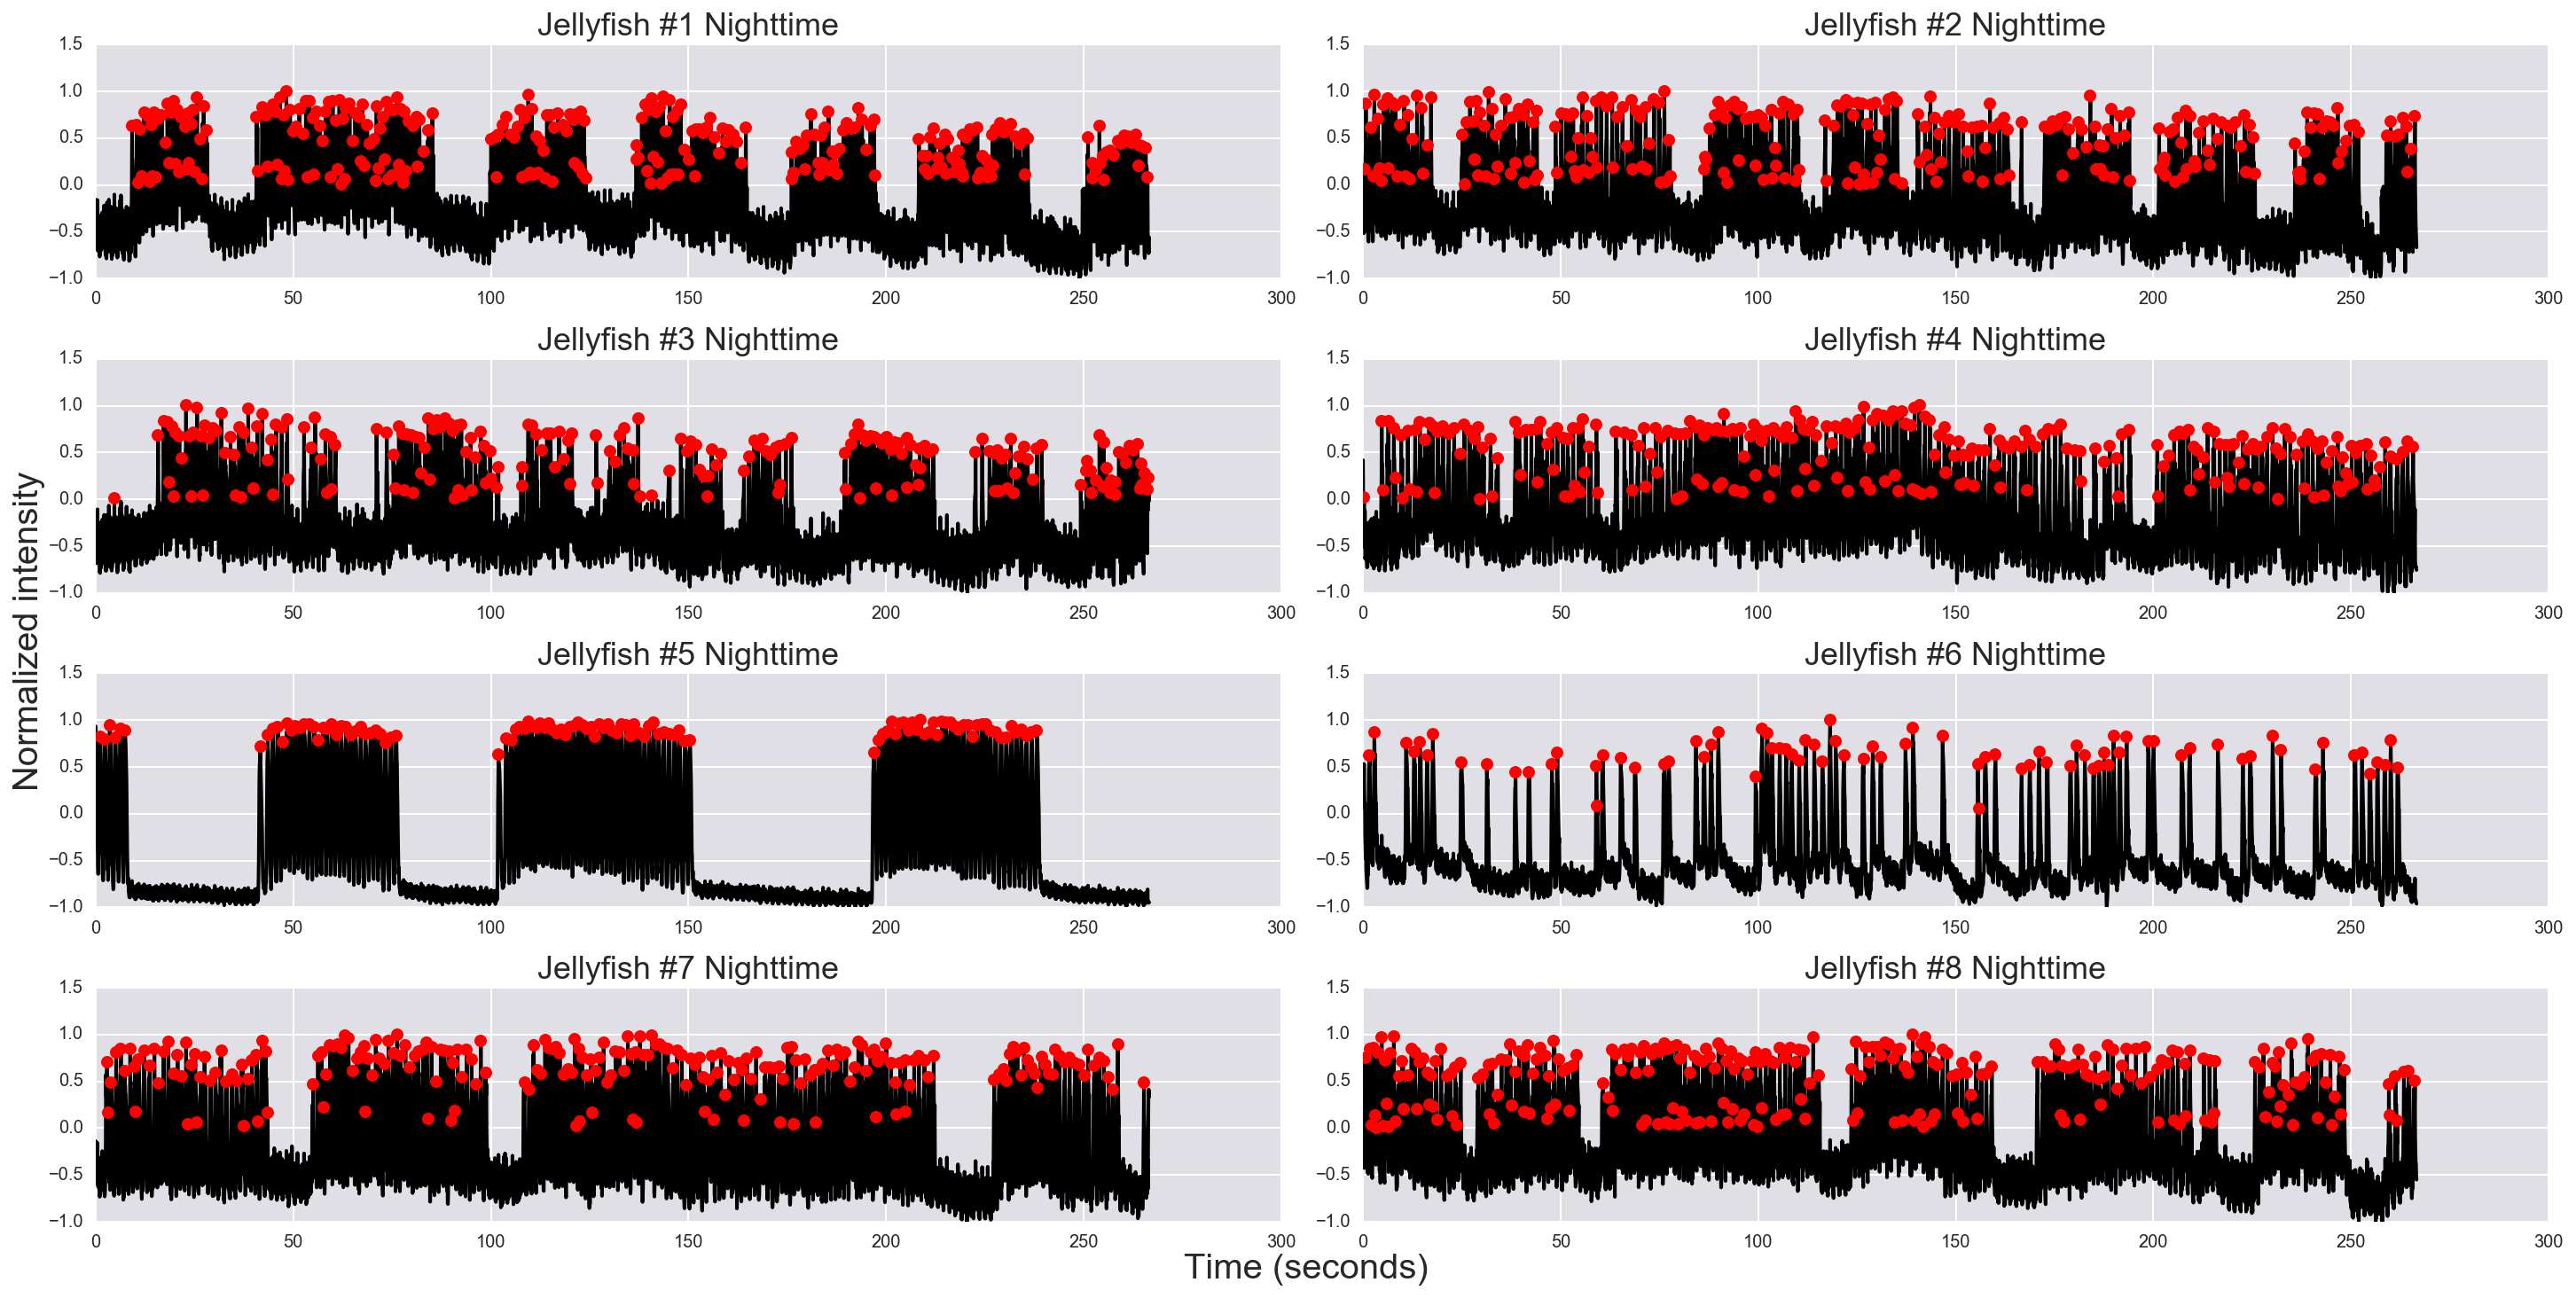

In [91]:
# Make plots for nighttime activity of each jellyfish
f = plt.figure(figsize=(20,10))
plt.subplot(4,2,1)
plt.plot(t_arr_night[0], total_int_arr_night[0], color='k')
plt.plot(t_peaks_list_night[0], peaks_list_night[0], marker='o', linestyle='None', color='r')
plt.title('Jellyfish #1 Nighttime')

plt.subplot(4,2,2)
plt.plot(t_arr_night[1], total_int_arr_night[1], color='k')
plt.plot(t_peaks_list_night[1], peaks_list_night[1], marker='o', linestyle='None', color='r')
plt.title('Jellyfish #2 Nighttime')

plt.subplot(4,2,3)
plt.plot(t_arr_night[2], total_int_arr_night[2], color='k')
plt.plot(t_peaks_list_night[2], peaks_list_night[2], marker='o', linestyle='None', color='r')
plt.title('Jellyfish #3 Nighttime')

plt.subplot(4,2,4)
plt.plot(t_arr_night[3], total_int_arr_night[3], color='k')
plt.plot(t_peaks_list_night[3], peaks_list_night[3], marker='o', linestyle='None', color='r')
plt.title('Jellyfish #4 Nighttime')

plt.subplot(4,2,5)
plt.plot(t_arr_night[4], total_int_arr_night[4], color='k')
plt.plot(t_peaks_list_night[4], peaks_list_night[4], marker='o', linestyle='None', color='r')
plt.title('Jellyfish #5 Nighttime')

plt.subplot(4,2,6)
plt.plot(t_arr_night[5], total_int_arr_night[5], color='k')
plt.plot(t_peaks_list_night[5], peaks_list_night[5], marker='o', linestyle='None', color='r')
plt.title('Jellyfish #6 Nighttime')

plt.subplot(4,2,7)
plt.plot(t_arr_night[6], total_int_arr_night[6], color='k')
plt.plot(t_peaks_list_night[6], peaks_list_night[6], marker='o', linestyle='None', color='r')
plt.title('Jellyfish #7 Nighttime')

plt.subplot(4,2,8)
plt.plot(t_arr_night[7], total_int_arr_night[7], color='k')
plt.plot(t_peaks_list_night[7], peaks_list_night[7], marker='o', linestyle='None', color='r')
plt.title('Jellyfish #8 Nighttime')

# Set common labels
f.text(0.5, 0.0, 'Time (seconds)', ha='center', va='center', fontsize=20)
f.text(0.0, 0.5, 'Normalized intensity', ha='center', va='center', rotation='vertical', fontsize=20)
plt.tight_layout()

Comparing day and night, we can already start to see some differences. It looks like for most if not all of the jellyfish, there is a greater number of obvious gaps in pulsing during the nighttime as compared to daytime.  

Our first step in analyzing the intercontraction times more directly was to calculate the mean intercontraction time for each jellyfish during the day and during the night. 

In [92]:
# Calculate mean of means to compare daytime and nighttime intercontraction times
mean_int_day = np.empty(len(all_verts))
mean_int_night = np.empty(len(all_verts))
for i in range(len(all_verts)):
    mean_int_day[i] = np.mean(t_int_list_day[i])
    mean_int_night[i] = np.mean(t_int_list_night[i])

Then we made boxplots to look at the difference between day and night across the jellyfish. 

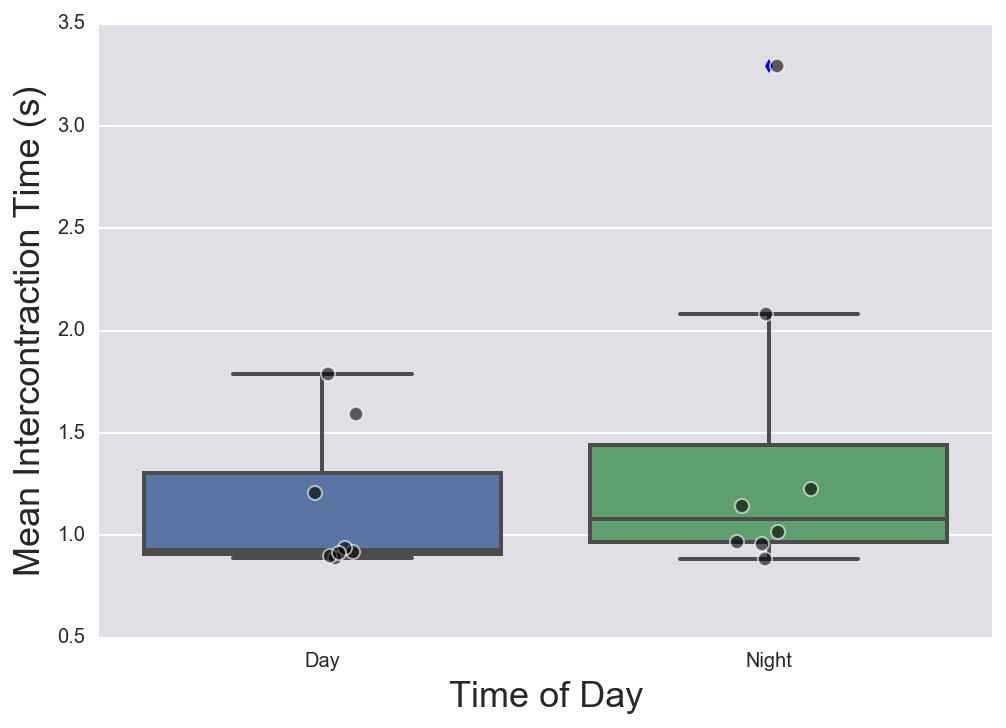

In [140]:
# Make boxplots to compare among individual jellyfish 
df = pd.DataFrame(columns=['Time of Day', 'Mean Intercontraction Time (s)'])
day_list = ['Day'] * 8
night_list = ['Night'] * 8
daynight_list = day_list + night_list
df['Time of Day'] = daynight_list
df['Mean Intercontraction Time (s)'] = np.concatenate((mean_int_day, mean_int_night))

ax = sns.boxplot(x=df['Time of Day'], y=df['Mean Intercontraction Time (s)'])
ax  = sns.stripplot(x=df['Time of Day'], 
                    y=df['Mean Intercontraction Time (s)'], 
                    data=df, 
                    jitter=True, 
                    alpha=0.6,
                    color='black')

It looks like overall the intercontraction times have some tendency to be higher during the nighttime, which would imply less activity and hence potentially point to a sleep-like phenomenon. However, there is quite a spread among the individual jellyfish, particularly during the nighttime, suggesting that this (sleep-like?) behavior is highly variable. 

We also wanted to compare day and night using a Cauchy distribution to estimate the mean of mean intercontraction times, since we see that there is at least one outlier jellyfish in the nighttime data (in the boxplot above). Previously we calculated the mean for each jellyfish essentially using a Gaussian distribution (the arithmetic mean being a shortcut as it is equivalent to the MAP for a Gaussian distribution). We did so because we saw that for some of the jellyfish, there were more obvious gaps in activity during the nighttime, but the gaps were still few in number compared to the large number of very short intercontraction times. To capture these gaps in our analysis (since they are the most apparent difference between day and night activity), we wanted a parameter that would be strongly affected by the few long gaps which might be considered "outliers" in some distributions (e.g. Cauchy). Therefore, we chose the Gaussian mean. However, when calculating the mean of means to make an overall comparison between day and night, we don't want outlier jellyfish to affect our results strongly, hence the decision to use a Cauchy distribution.

In [175]:
@jit(nopython=True)

def log_posterior(p, x, x_min=0, x_max=300):
    """
    Log posterior for Cauchy distribution.  
    
    x = activity levels, but can be anything we measure repeatedly.
    
    p[0] = parameter we're estimating (mean mean activity in this case)
    p[1] = beta (Cauchy scale parameter)
    x_min = kind of obvious.
    x_max = 300s (based on the data)
    """
    
    # Unpack parameters
    mu, beta = p
    
    if (mu < x_min) or (mu > x_max) or (beta <= 0.0):
        return -np.inf
    
    return -(len(x) + 1) * np.log(beta) \
                    - np.sum(np.log(1.0 + ((x - mu) / beta)**2))

def cauchy_mcmc(data, n_dim=2, n_walkers=100, n_burn=1000, n_steps=10000, log_post=log_posterior):
    
    # Generate random starting points for walkers.  
    # p0[i,j] is the starting point for walk i along variable j.
    p0 = np.empty((n_walkers, n_dim))
    p0[:,0] = np.random.uniform(0.0, 300.0, n_walkers)     # mu
    p0[:,1] = np.random.exponential(1.0, n_walkers)      # beta

    args = (data,)
    # Set up the EnsembleSampler instance
    sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post, args=args)
    
    # Burn in
    pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)
    
    # Run MCMC
    _ = sampler.run_mcmc(pos, n_steps)

    # Find MAPs
    max_ind = np.argmax(sampler.flatlnprobability)
    mu_MAP, beta_MAP = sampler.flatchain[max_ind,:]
    
    return mu_MAP, sampler.flatchain

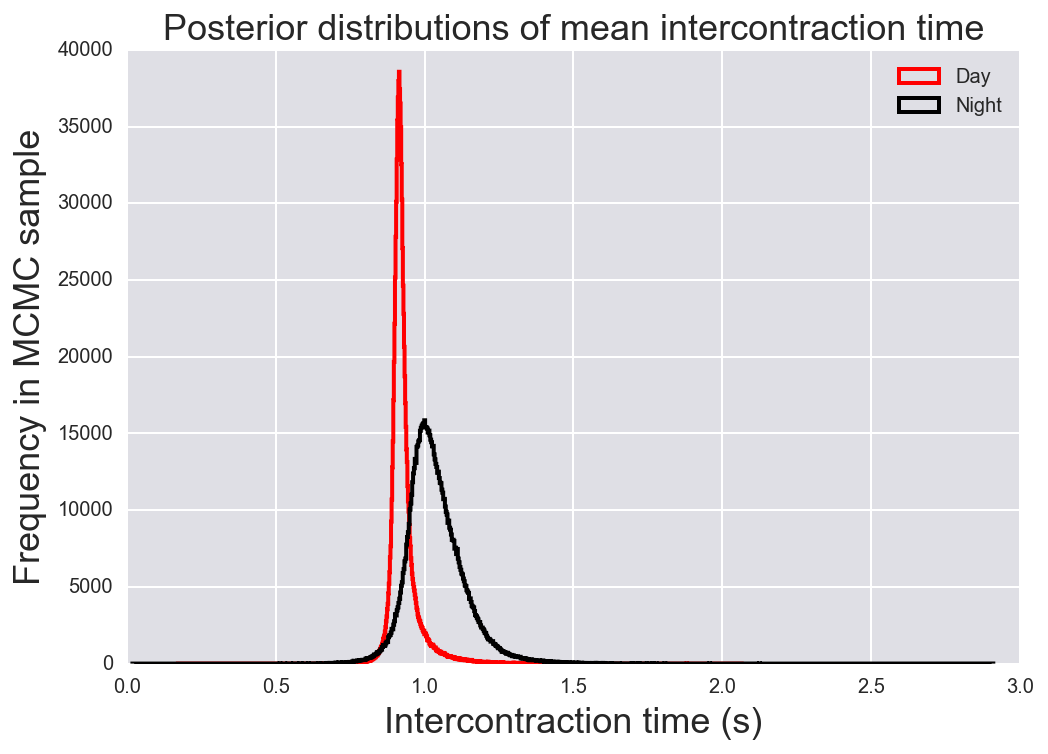

In [183]:
# Run MCMC for day and night
mu_MAP_day, flatchain_day = cauchy_mcmc(mean_int_day) 
mu_MAP_night, flatchain_night = cauchy_mcmc(mean_int_night)

# Plot posterior distributions of µ
_ = plt.hist(flatchain_day[:,0], bins=1000, histtype='step', color='r', lw=2)
_ = plt.hist(flatchain_night[:,0], bins=1000, histtype='step', color='k', lw=2)
plt.legend(['Day', 'Night'])
plt.title('Posterior distributions of mean intercontraction time')
plt.xlabel('Intercontraction time (s)')
plt.ylabel('Frequency in MCMC sample')

As with the box plots, we see a small difference between day and night, with the mean intercontraction time being somewhat higher on average during the night. To calculate an effect size, we used Cohen's d. 

In [155]:
def pooled_std(data1, data2):
    """
    Calculate the pooled standard deviation for two independent samples.
    """
    return np.sqrt(((len(data1)-1)*(data1.std()**2)+(len(data2)-1)*(data2.std()**2))/(len(data1)+len(data2)-2))

def cohen_d(data1, data2):
    """
    Calculate Cohen's d for two independent samples.
    """
    return (data1.mean() - data2.mean())/pooled_std(data1, data2)

# Calculate effect size for wild-type cross-sections and anti-Venus
effect_size = abs(cohen_d(mean_int_day, mean_int_night))

print('Effect size = ' + str(effect_size))

Effect size = 0.500314999373


We weren't initially sure that we would consider a Cohen's d of only ~0.5 to be significant in this context, as it seems rather small. However, looking again at the plots of the raw data and peaks (shown above), it still seems pretty clear that the activity follows different patterns between day and night for most of the jellyfish. 

We looked next at each jellyfish separately to compare day and night pulsing activity using the Student t-distribution to estimate the means (similar to Tutorial 2). We used the Student t-distribution because it is the form of the Gaussian distribution marginalized over $\sigma$ (which we are not concerned with), and assuming a Gaussian distribution seems reasonable based on the central limit theorem.  

In [168]:
def student_t(mu, x):
    """
    Returns the Student-t distribution for values of mu with data x.
    We could use scipy.stats for this, but we'll do it ourselves.
    """
    # Number of data
    n = len(x)
    
    # Mean of data
    x_mean = x.mean()
    
    # Compute r^2
    r2 = ((x - x_mean)**2).sum() / n
    
    # Compute the mu-dependent part
    t = (1.0 + (mu - x_mean)**2 / r2)**(-n / 2.0)
    
    # Normalize and return
    return -scipy.special.beta(-0.5, n / 2.0) / 2.0 / np.pi / np.sqrt(r2) * t

mu = np.linspace(0.0, 6.0, 1000)
post_day = np.empty((len(all_verts), len(mu)))
post_night = np.empty((len(all_verts), len(mu)))
for i in range(len(all_verts)):
    post_day[i,:] = student_t(mu, t_int_list_day[i])
    post_night[i,:] = student_t(mu, t_int_list_night[i])

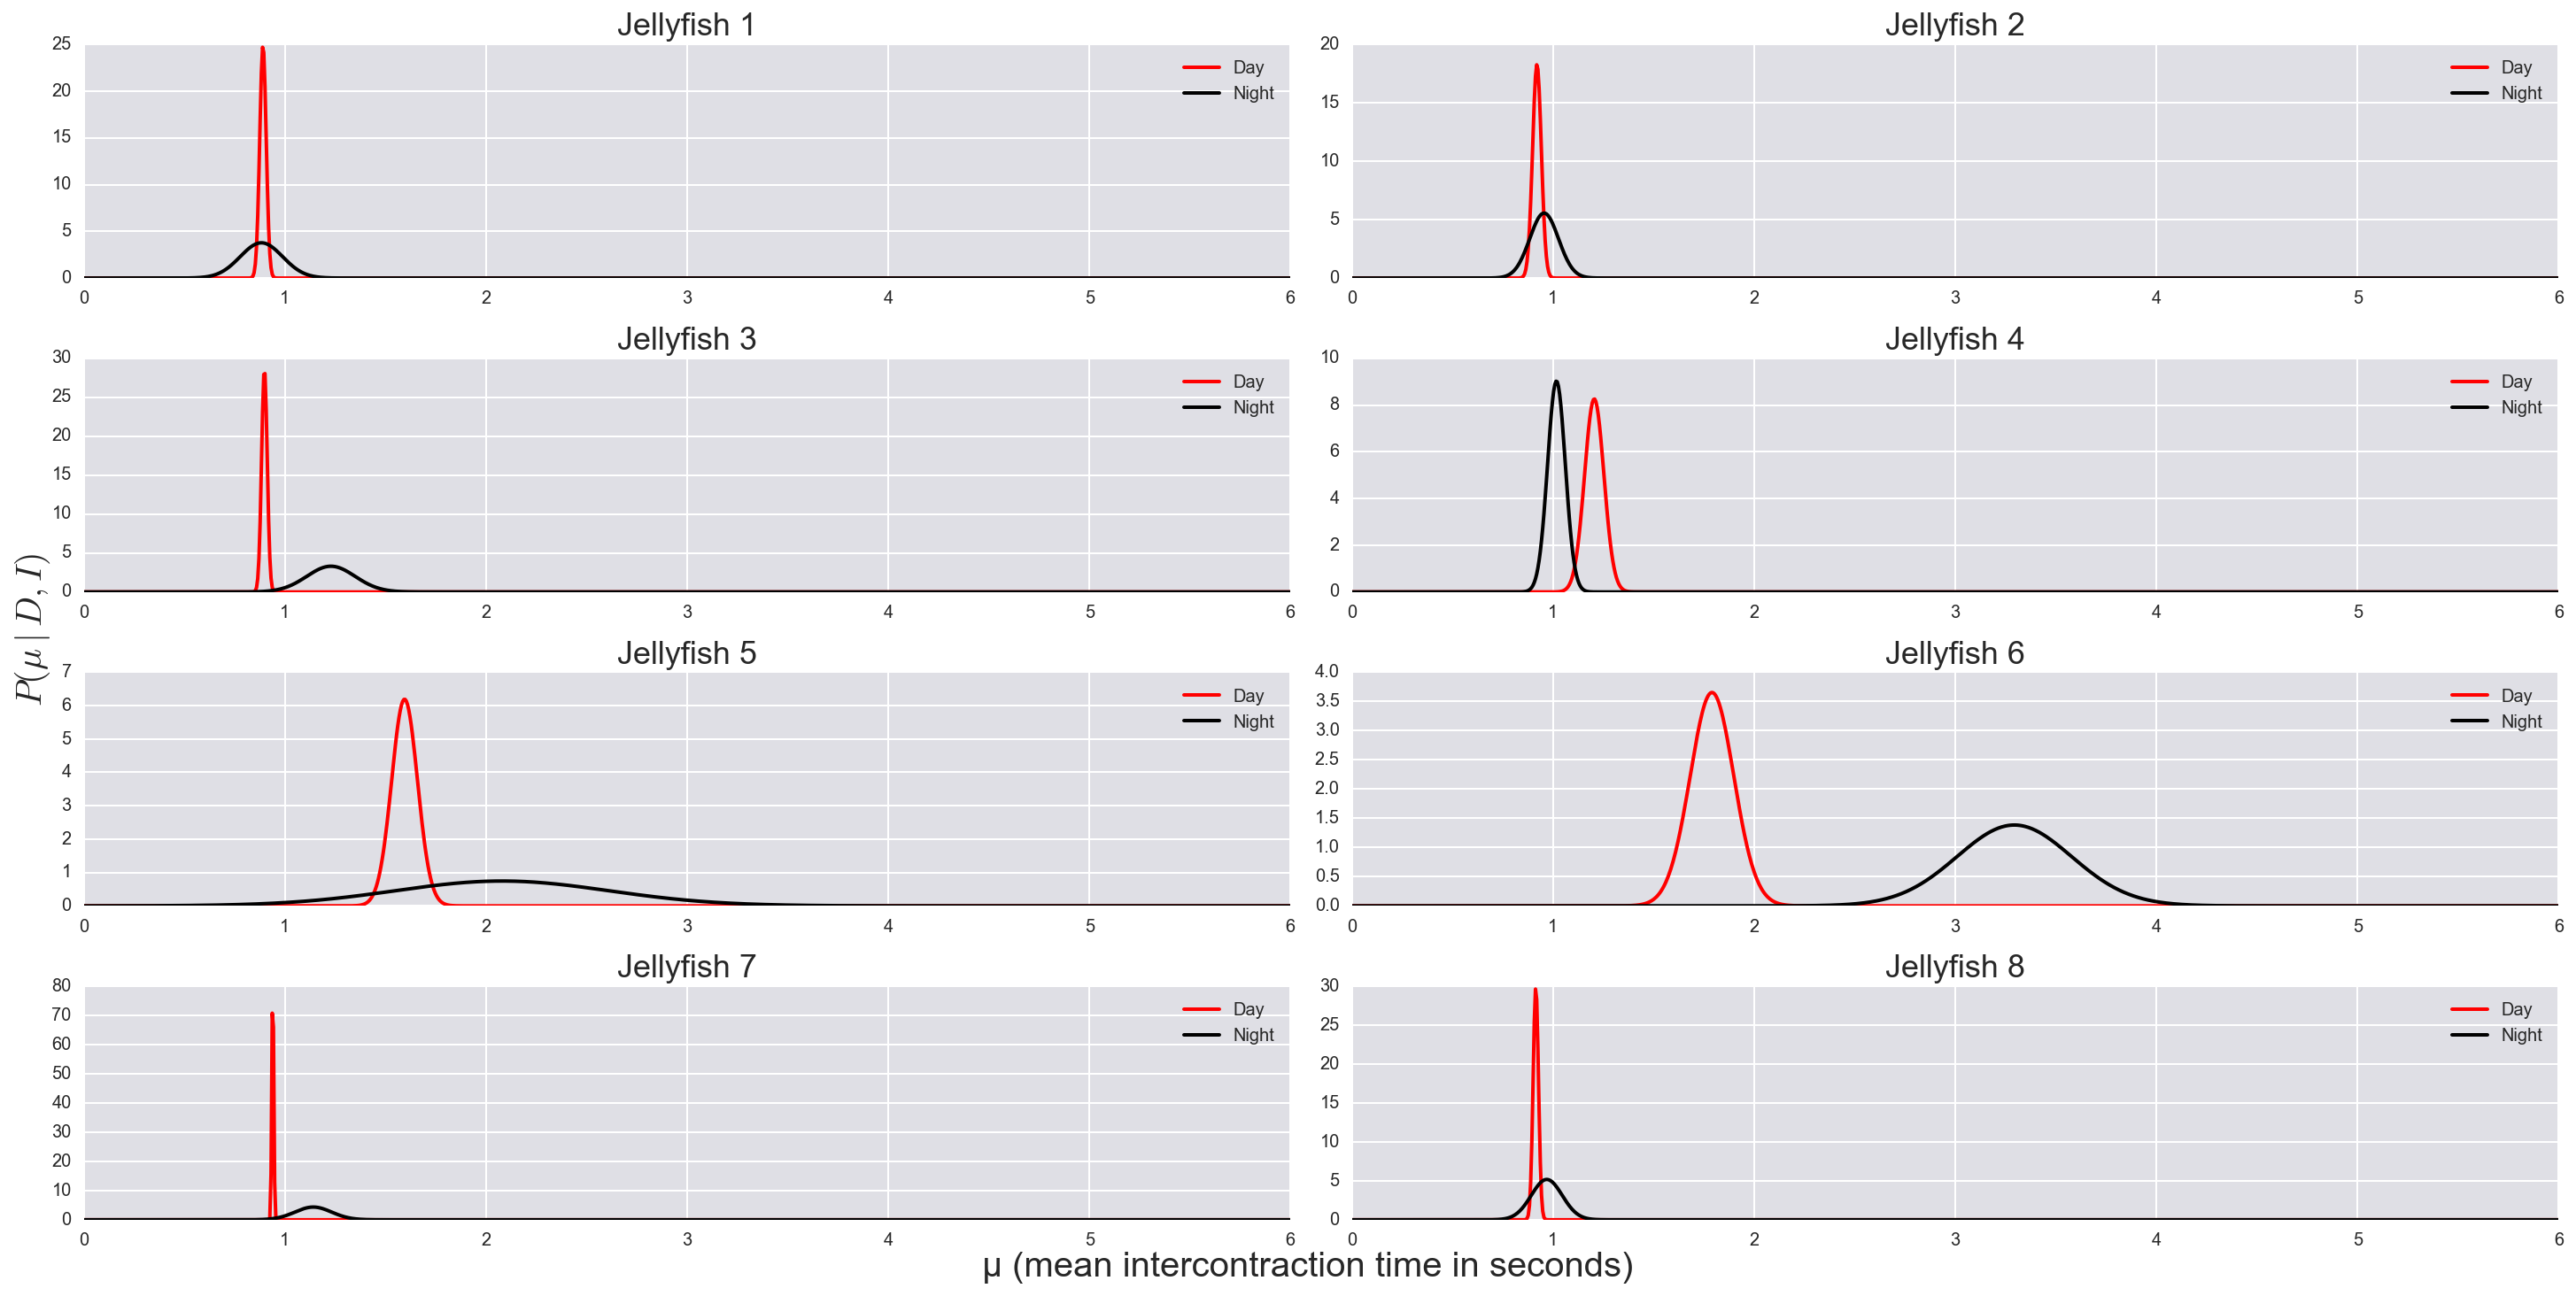

In [169]:
# Plot the Student t-distributions for day and night for each jellyfish
f = plt.figure(figsize=(20,10))

plt.subplot(4,2,1)
plt.plot(mu, post_day[0], color='r')
plt.plot(mu, post_night[0], color='k')
plt.title('Jellyfish 1')
plt.legend(['Day', 'Night'])

plt.subplot(4,2,2)
plt.plot(mu, post_day[1], color='r')
plt.plot(mu, post_night[1], color='k')
plt.title('Jellyfish 2')
plt.legend(['Day', 'Night'])

plt.subplot(4,2,3)
plt.plot(mu, post_day[2], color='r')
plt.plot(mu, post_night[2], color='k')
plt.title('Jellyfish 3')
plt.legend(['Day', 'Night'])

plt.subplot(4,2,4)
plt.plot(mu, post_day[3], color='r')
plt.plot(mu, post_night[3], color='k')
plt.title('Jellyfish 4')
plt.legend(['Day', 'Night'])

plt.subplot(4,2,5)
plt.plot(mu, post_day[4], color='r')
plt.plot(mu, post_night[4], color='k')
plt.title('Jellyfish 5')
plt.legend(['Day', 'Night'])

plt.subplot(4,2,6)
plt.plot(mu, post_day[5], color='r')
plt.plot(mu, post_night[5], color='k')
plt.title('Jellyfish 6')
plt.legend(['Day', 'Night'])

plt.subplot(4,2,7)
plt.plot(mu, post_day[6], color='r')
plt.plot(mu, post_night[6], color='k')
plt.title('Jellyfish 7')
plt.legend(['Day', 'Night'])

plt.subplot(4,2,8)
plt.plot(mu, post_day[7], color='r')
plt.plot(mu, post_night[7], color='k')
plt.title('Jellyfish 8')
plt.legend(['Day', 'Night'])

# Set common labels
f.text(0.5, 0.0, 'µ (mean intercontraction time in seconds)', ha='center', va='center', fontsize=20)
f.text(0.0, 0.5, r'$P(\mu \mid D, I)$', ha='center', va='center', rotation='vertical', fontsize=20)
plt.tight_layout()

Interesting - the relationship between daytime and nighttime mean intercontraction time seems to be quite variable. For jellyfish 1 and 2, the mean intercontraction time is basically the same for both day and night. For jellyfish 3, 5, 6, 7, and perhaps 8, the mean intercontraction time seems to be clearly higher at night (implying periods of rest and/or less activity in general). For jellyfish 4, however, the mean is actually higher during the day! To get a better understanding of what is going on, our final tool for analysis was to plot day and night ECDFs for each jellyfish. 

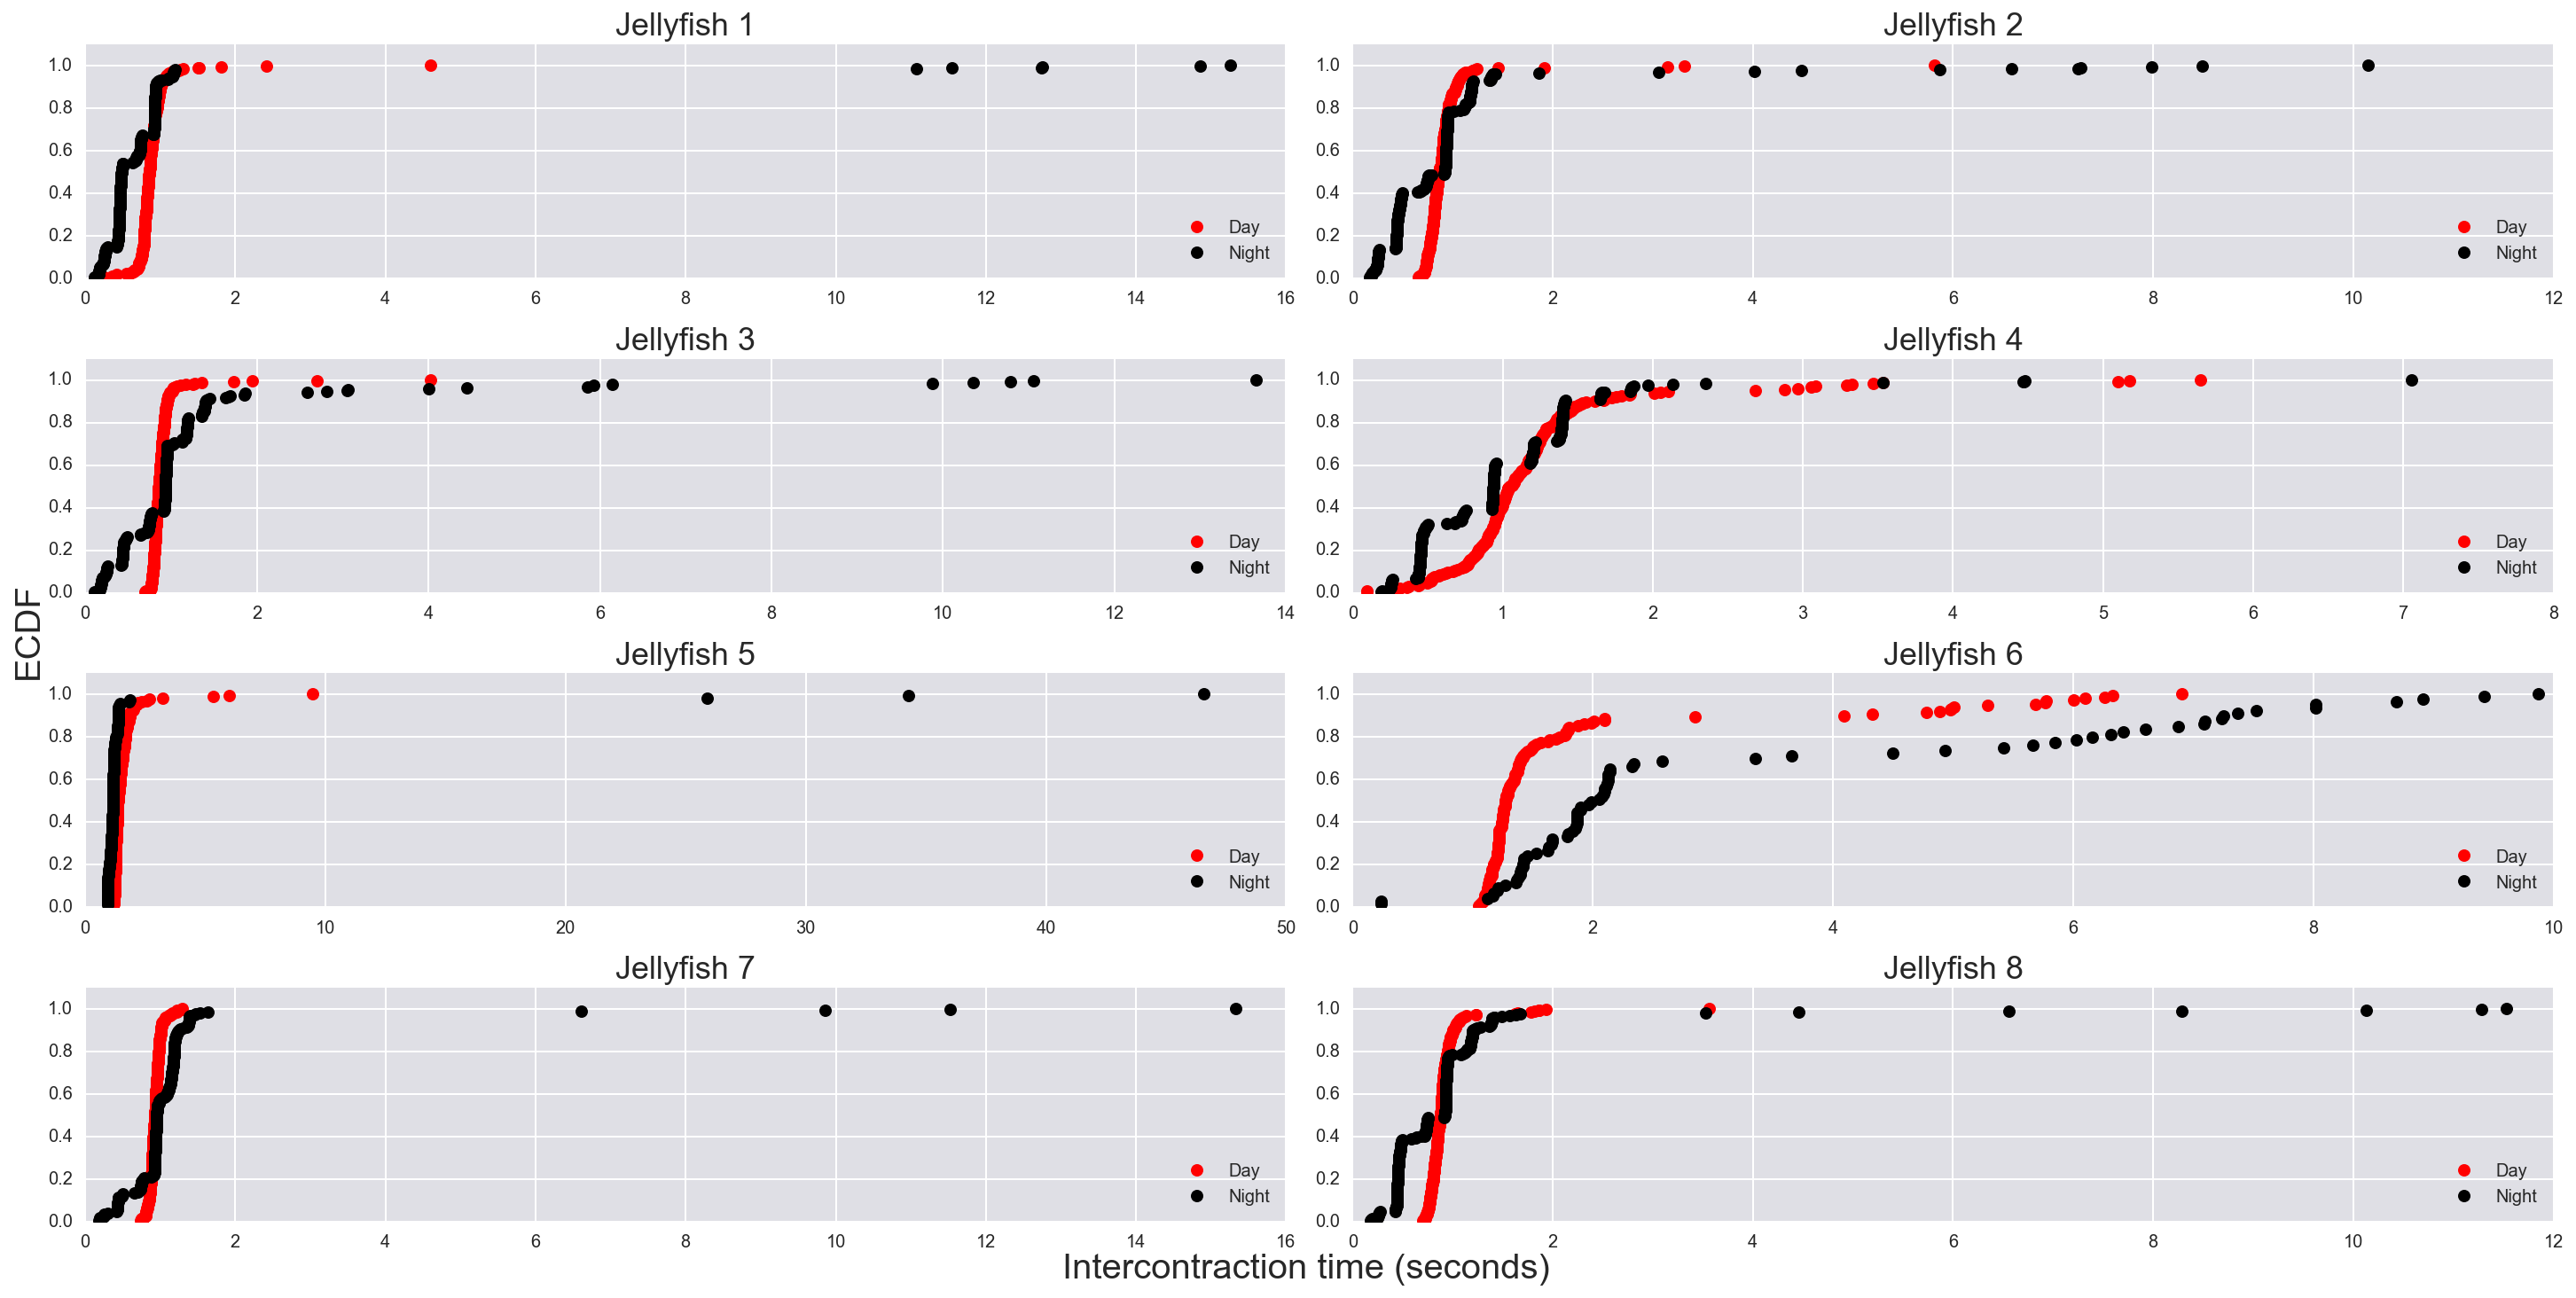

In [187]:
f = plt.figure(figsize=(20,10))

for i in range(1,9):
    plt.subplot(4,2,i)
    x_day = np.sort(t_int_list_day[i-1])
    y_day = np.arange(1, len(x_day)+1) / len(x_day)
    x_night = np.sort(t_int_list_night[i-1])
    y_night = np.arange(1, len(x_night)+1) / len(x_night)
    plt.plot(x_day, y_day, 'o', color='r')
    plt.plot(x_night, y_night, 'o', color='k')
    plt.ylim([0,1.1])
    plt.title('Jellyfish ' + str(i))
    plt.legend(['Day', 'Night'], loc=4)
    
# Set common labels
f.text(0.5, 0.0, 'Intercontraction time (seconds)', ha='center', va='center', fontsize=20)
f.text(0.0, 0.5, 'ECDF', ha='center', va='center', rotation='vertical', fontsize=20)
plt.tight_layout()

We think the ECDFs are more informative than simply looking at the means. We can see that for all of the jellyfish (except perhaps jellyfish 4), several relatively long intercontraction times occurred during the night as compared to the day. Jellyfish 4 is unusual in that its daytime intercontraction times tended to be longer in general compared to the other jellyfish, and its daytime and nighttime activity look pretty similar.

Overall, looking at the raw data (with the peaks marked) and the ECDFs, there does seem to be a general tendency for sporadic long intercontraction times to occur preferentially at night as opposed to during the day. This could tentatively be interpreted as supporting the hypothesis that jellyfish exhibit sleep-like behavior at night. However, the pulsing behavior is quite variable among individual jellyfish, so we hesitate to state a firm conclusion. To get a better idea of whether the jellyfish are truly exhibiting sleep-like behavior, one followup experiment could be to wait until the jellyfish have a relatively long break in pulsing, and then apply some stimulus (e.g. poking them, shining light of different wavelengths, etc.) to see how long it takes them to respond and resume pulsing. If the response to the stimulus is slower than when they are not in the middle of an extended break in pulsing, that would support the idea that those breaks represent sleep-like behavior (one of the criteria for "sleep" is an increased response threshold or response latency). 

Finally, we note that this dataset proved to be very instructive in the importance of choosing how to display and analyze one's data so as to reveal interesting trends. Some typical approaches like calculating means ended up nearly obscuring the interesting observation about exactly how day and night activity differ. 